In [1]:
%load_ext autoreload
%load_ext dotenv
%dotenv -o

In [2]:
%%capture
%pip install langchain langchain_community
%pip install faiss-gpu faiss-cpu
%pip install langchain-cohere
%pip install langgraph
%pip install langchain-google-community

In [3]:
import os

current_directory = os.getcwd()

workspace_directory = os.path.abspath(os.path.join(current_directory, ".."))
print(workspace_directory)

/home/izlobin/wd/events-planner-agents


In [4]:
from typing import Literal

from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.types import Command

model = ChatOpenAI(api_key=os.getenv("OPENAI_API_KEY"), model=os.getenv("OPENAI_API_MODEL_NAME", "gpt-4o-mini"))


def agent_1(state: MessagesState) -> Command[Literal["agent_2", "agent_3", END]]:
    response = model.invoke(state["messages"])
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )


def agent_2(state: MessagesState) -> Command[Literal["agent_1", "agent_3", END]]:
    response = model.invoke(state["messages"])
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )


def agent_3(state: MessagesState) -> Command[Literal["agent_1", "agent_2", END]]:
    response = model.invoke(state["messages"])
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )


builder = StateGraph(MessagesState)
builder.add_node(agent_1)
builder.add_node(agent_2)
builder.add_node(agent_3)

builder.add_edge(START, "agent_1")
network = builder.compile()

In [6]:
for event in network.stream({"messages": [{"role": "user", "content": "What's the square root of 42?"}]}, subgraphs=True):
    print(event)
    print("----")

TypeError: 'AIMessage' object is not subscriptable

In [5]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_google_community import GoogleSearchAPIWrapper

# tavily_tool = TavilySearchResults(max_results=5)
search_tool = GoogleSearchAPIWrapper()

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."

In [4]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [9]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage

# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command
import os


# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
llm = ChatOpenAI(api_key=os.getenv("OPENAI_API_KEY"), model=os.getenv("OPENAI_API_MODEL_NAME", "gpt-4o-mini"))


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[search_tool.run],
    prompt=make_system_prompt("You can only do research. You are working with a chart generator colleague."),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt("You can only generate charts. You are working with a researcher colleague."),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [10]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

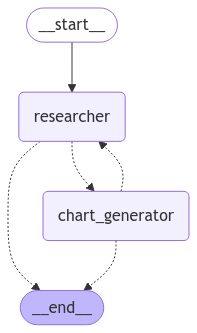

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='927d1c7a-4328-4fdb-aa3d-5befeab4feac'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zu3NrYkBgFAnpik7Dxep3X71', 'function': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'run'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 174, 'total_tokens': 195, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-704a3708-3e4b-4b36-81f2-7e6c295da6a8-0', tool_calls=[{'name': 'run', 'args': {'qu

Python REPL can execute arbitrary code. Use with caution.


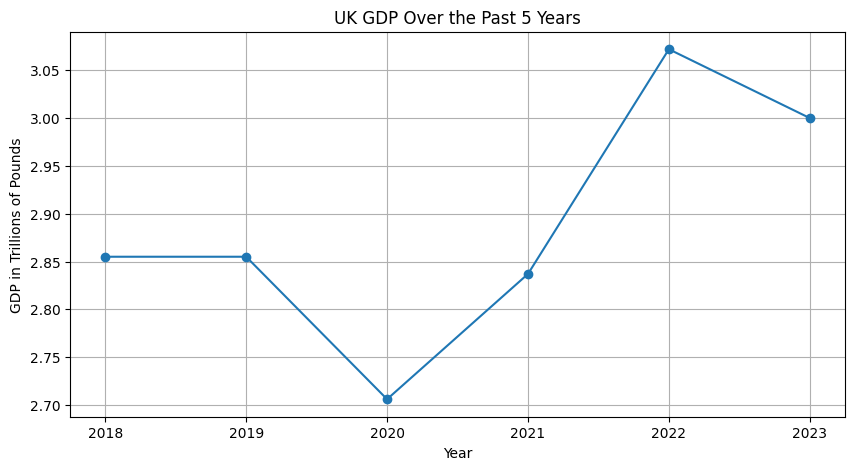

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='927d1c7a-4328-4fdb-aa3d-5befeab4feac'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zu3NrYkBgFAnpik7Dxep3X71', 'function': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'run'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 174, 'total_tokens': 195, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-704a3708-3e4b-4b36-81f2-7e6c295da6a8-0', tool_calls=[{'name': 'run', 'args':

In [ ]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")